In [1]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt

from multiprocessing import cpu_count
from multiprocessing import Pool

병렬 처리에 사용될 코드

In [2]:
num_cores = cpu_count()

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_cores)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [3]:
dg_df = pd.read_csv('./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/Demographics.csv')
dg_df.head(16)

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


In [4]:
df = pd.read_csv(r'./features.csv', sep='\t', encoding='utf-8')

In [5]:
df = df.dropna().drop(columns=['Unnamed: 0']).reset_index(drop=True)

In [6]:
df.isna().sum()

calories2hr       0
protein2hr        0
sugar2hr          0
carbs2hr          0
calories8hr       0
                 ..
ID                0
HbA1c             0
Biological Sex    0
CVSD              0
label             0
Length: 89, dtype: int64

In [7]:
df['Biological Sex'] = df['Biological Sex'].map({'FEMALE': 0, 'MALE': 1})

In [8]:
df['label'] = df['label'].map({'PersLow': 0, 'PersNorm': 1, 'PersHigh':2})

### 상관관계 Matrix Heat map

In [9]:
corrdf = df.drop(columns=['datetime']).corr()

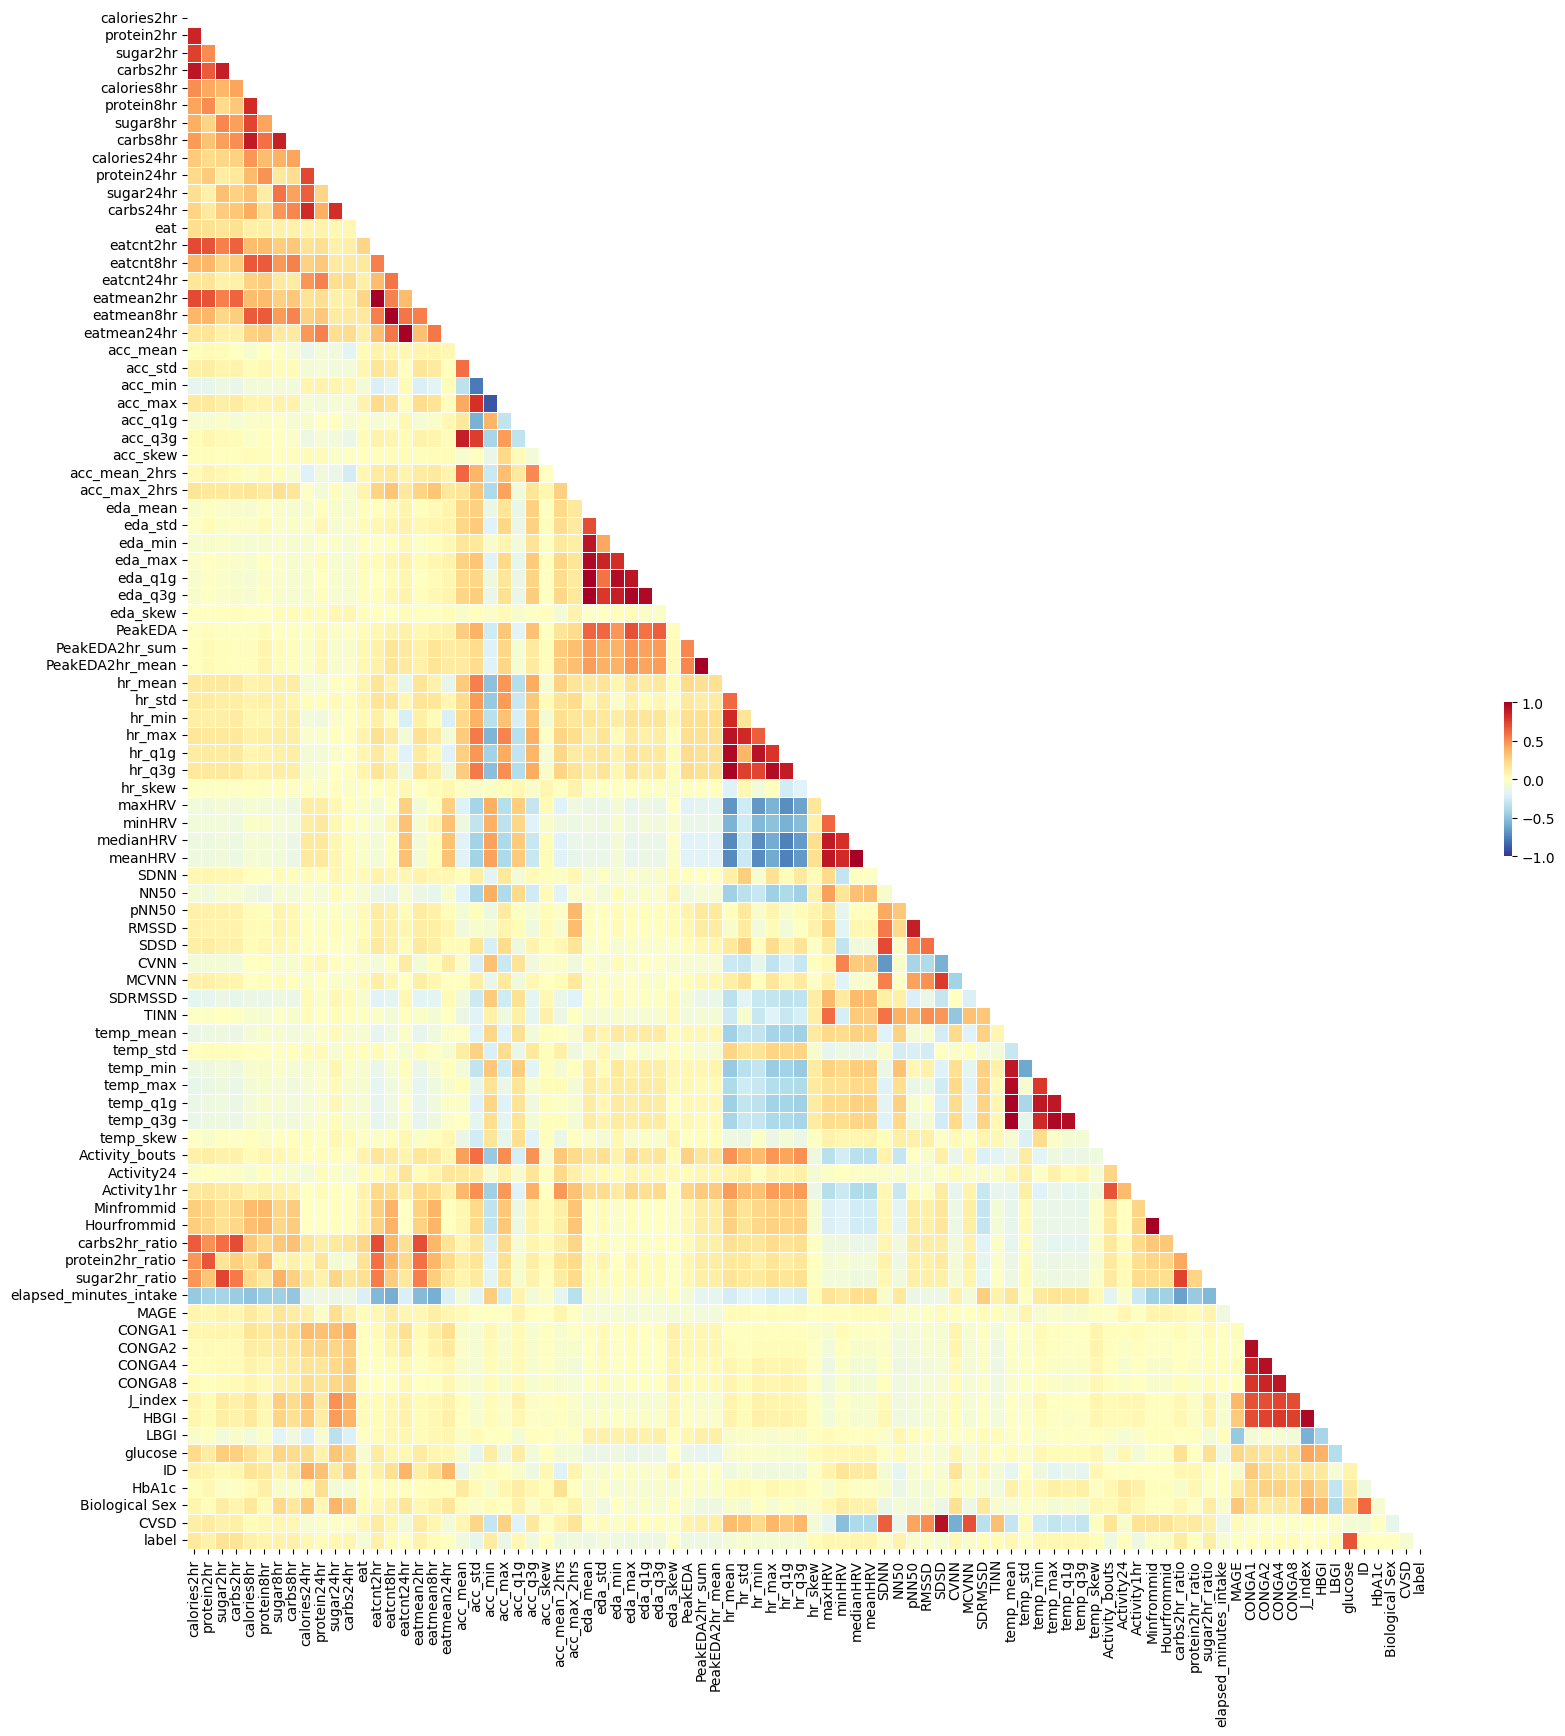

In [10]:
import seaborn as sns

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(20,20) )

mask = np.zeros_like(corrdf)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(corrdf, 
            cmap = 'RdYlBu_r', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .1},# 컬러바 크기 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

## 1. 독립적 교차 검증(subject-independent cross-validation), LOSO(Leave-One-Subject-Out) Model

### Leave-one-person-out cross validation Random forest regression 모델을 이용한 간질 포도당 예측에 대한 기여도 결정

In [11]:
def LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000):
    """
        Intermediate function. Please use loocvRF function.
            
    """
    # Separate data for leave-one-person-out-cross-validation (LOOCV)
    LOOCV_O = ids 
    data[idcolumn] = data[idcolumn].apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]
    
    print(len(data_filtered))
    print(len(data_cv))
    
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    
    from sklearn.ensemble import RandomForestRegressor
    # Instantiate model with numestimators decision trees
    rf = RandomForestRegressor(n_estimators = numestimators, random_state = 0)
    # Train the model on training data
    print('Now processing... LOOCV_featureselection')
    rf.fit(X_train, y_train)
    
    # Get importances:
    importances = list(rf.feature_importances_)# List of tuples with variable and importance
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    
    return important

def RFLOOCV(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000, fs=0.02):
    """
        Intermediate function. Please use loocvRF function.
            
    """
    # Get important features
    listimportances = LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators)
    filteredi = listimportances[listimportances['importances'] < fs]
    filteredi = filteredi['value']
    
    LOOCV_O = str(ids)
    data[idcolumn] = data[idcolumn].apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')
   
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    data_test = data_test.drop(columns=filteredi) #cvf
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    data_train = data_train.drop(columns=filteredi)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    
    from sklearn.ensemble import RandomForestRegressor# Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = numestimators, random_state = 0)# Train the model on training data
    print('Now processing... RFLOOCV')
    rf.fit(X_train, y_train)
    
    # Use the forest's predict method on the test data
    predictions = rf.predict(X_test)
    errors = abs(predictions - y_test)
    
    # Root Mean Squared Error (RMSE)
    from sklearn import metrics
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions))
    
    # Mean Average Percent Error (MAPE)
    MAPerror = np.mean(np.abs((y_test - predictions) / y_test)) * 100 
    
    # List of tuples with variable and importance
    importances = list(rf.feature_importances_)
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    important['id'] = str(ids)
    
    return errors, RMSE, MAPerror, important

def loocvRF(data, idcolumn, outcomevar, dropcols=[], numestimators=1000, fs=0.02):
    """
        Main loocv RF function that calls other functions to do RF feature selection, training, and testing. 

        Args:
          data (pandas DataFrame): This is a dataframe containing each participant's features and outcome variables
          idcolumn (string): This is the column name of your column containing your participant number or ID (case sensitive)
          outcomevar (string): This is the column name of your outcome variable (case sensitive)
          dropcols (list): This is a list containing strings of each column you wish to drop in your dataframe. Default is empty list [].
          numestimators (integer): The number of trees you want built in your RF. Default=1000.
          fs (float): The cutoff importance for feature selection. Anything below this importance will be removed for the RF training.
          
        Returns:
            errors (list): This is a list with the absolute error between the predicted value and actual value for each fold.
            meanrmse (float): This is the mean root mean squared error (RMSE) over all of the folds
            stdrmse (float): This is the standard deviation of the root mean squared error (RMSE) over all of the folds
            meanrmse (float): This is the mean mean average percent error (MAPE) over all of the folds
            meanrmse (float): This is the standard deviation of the mean average percent error (MAPE) over all of the folds
            importances(pandas DataFrame): This is a pandas DataFrame with 3 columns: value (feature), importances (importance of the feature), and id (fold over which this feature importance was derived)
            
    """
    
    # Make list of all ID's in idcolumn
    IDlist = list(data[idcolumn].astype(str).unique())
    print(f'IDlist : {IDlist}')
    drop = [] #drop = [idcolumn]
    drop = drop + dropcols
    
    # Initialize empty lists and dataframe 
    errors = []
    rmse = []
    mape = []
    eval_metrics = pd.DataFrame(columns=['rmse', 'mape', 'id'])
    importances = pd.DataFrame(columns=['value', 'importances', 'id'])
    
    # Run LOOCV Random Forest! 
    for i in IDlist:
        er, rm, ma, imp= RFLOOCV(data, i, outcomevar, drop, idcolumn, numestimators, fs)
        errors.append(er)
        rmse.append(rm)
        mape.append(ma)
        eval = pd.DataFrame({'rmse': [rm], 'mape': [ma], 'id': [str(i)]})
        eval_metrics = pd.concat([eval_metrics, eval], ignore_index=True)
        importances = pd.concat([importances, imp], ignore_index=True)
        idt = str(i)
        print('...' + idt + ' processing complete.')

    # Compute mean and std RMSE, MAPE
    meanrmse = np.mean(rmse)
    stdrmse = np.std(rmse)
    meanmape = np.mean(mape)
    stdmape = np.std(mape)
    
    # Print RMSE, MAPE
    print('Mean RMSE:' + str(meanrmse))
    print('Std RMSE:' + str(stdrmse))
    print('Mean MAPE:' + str(meanmape))
    print('Std MAPE:' + str(stdmape))
    
    return eval_metrics, errors, meanrmse, stdrmse, meanmape, stdmape, importances

In [12]:
#errors, RMSE, RMSEstd, MAPE, MAPEstd, importances = loocvRF(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'], numestimators=1000, fs=0.02)
eval_df, errors, RMSE, RMSEstd, MAPE, MAPEstd, importances = loocvRF(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'], numestimators=100, fs=0.02)

IDlist : ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '16.0']
28870
2310
Now processing... LOOCV_featureselection
LOOCV_O : 1.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/tmp/ipykernel_75316/3769959825.py:144: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_metrics = pd.concat([eval_metrics, eval], ignore_index=True)
/tmp/ipykernel_75316/3769959825.py:145: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  importances = pd.concat([importances, imp], ignore_index=True)


...1.0 processing complete.
29182
1998
Now processing... LOOCV_featureselection
LOOCV_O : 2.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...2.0 processing complete.
29155
2025
Now processing... LOOCV_featureselection
LOOCV_O : 3.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...3.0 processing complete.
29213
1967
Now processing... LOOCV_featureselection
LOOCV_O : 4.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...4.0 processing complete.
28897
2283
Now processing... LOOCV_featureselection
LOOCV_O : 5.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...5.0 processing complete.
28622
2558
Now processing... LOOCV_featureselection
LOOCV_O : 6.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...6.0 processing complete.
29184
1996
Now processing... LOOCV_featureselection
LOOCV_O : 7.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...7.0 processing complete.
28905
2275
Now processing... LOOCV_featureselection
LOOCV_O : 8.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...8.0 processing complete.
29163
2017
Now processing... LOOCV_featureselection
LOOCV_O : 9.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...9.0 processing complete.
29189
1991
Now processing... LOOCV_featureselection
LOOCV_O : 10.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...10.0 processing complete.
28613
2567
Now processing... LOOCV_featureselection
LOOCV_O : 11.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...11.0 processing complete.
29264
1916
Now processing... LOOCV_featureselection
LOOCV_O : 12.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...12.0 processing complete.
29491
1689
Now processing... LOOCV_featureselection
LOOCV_O : 13.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...13.0 processing complete.
29319
1861
Now processing... LOOCV_featureselection
LOOCV_O : 14.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...14.0 processing complete.
29453
1727
Now processing... LOOCV_featureselection
LOOCV_O : 16.0
Now processing... RFLOOCV
...16.0 processing complete.
Mean RMSE:20.53312818602508
Std RMSE:4.39530152578095
Mean MAPE:13.561671688226507
Std MAPE:2.856633162066255


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [13]:
eval_df.head(20)

,rmse,mape,id
0,15.240348,10.775675,1.0
1,22.547121,14.374788,2.0
2,18.678964,12.417549,3.0
3,20.423097,13.894243,4.0
4,12.915140,10.344655,5.0
5,28.615037,18.409859,6.0
6,20.137574,19.396390,7.0
7,13.632974,9.454924,8.0
8,21.390547,12.131940,9.0
9,28.653381,16.783673,10.0


In [14]:
print(importances)

               value  importances    id
0           sugar2hr     0.049347   1.0
1           carbs2hr     0.091924   1.0
2       acc_max_2hrs     0.077400   1.0
3    PeakEDA2hr_mean     0.081479   1.0
4         Minfrommid     0.139165   1.0
..               ...          ...   ...
131             MAGE     0.076986  16.0
132          J_index     0.239942  16.0
133             LBGI     0.135397  16.0
134               ID     0.061700  16.0
135            HbA1c     0.044113  16.0

[136 rows x 3 columns]


In [15]:
imp_err = importances.groupby('value').std(numeric_only=True).rename(columns={'importances':'std'})#.sort_values(by='importances', ascending=False)

In [16]:
imp_err.head()

,std
value,
Activity24,0.010258
HbA1c,0.010340
ID,NaN
J_index,0.014545
LBGI,0.011582


In [17]:
filteredimp = importances.groupby('value').mean(numeric_only=True).sort_values(by='importances', ascending=False)
filteredimp = pd.merge(filteredimp, imp_err, on='value')
print(filteredimp)

                        importances       std
value                                        
J_index                    0.248777  0.014545
Minfrommid                 0.135861  0.010974
LBGI                       0.123751  0.011582
carbs2hr                   0.103287  0.012787
elapsed_minutes_intake     0.097764  0.006538
sugar8hr                   0.093469       NaN
Activity24                 0.084559  0.010258
PeakEDA2hr_mean            0.076231  0.006955
calories8hr                0.073365       NaN
acc_max_2hrs               0.071465  0.008471
MAGE                       0.070553  0.005534
ID                         0.061700       NaN
HbA1c                      0.059496  0.010340
sugar2hr                   0.048007  0.001406


/tmp/ipykernel_75316/3888890867.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


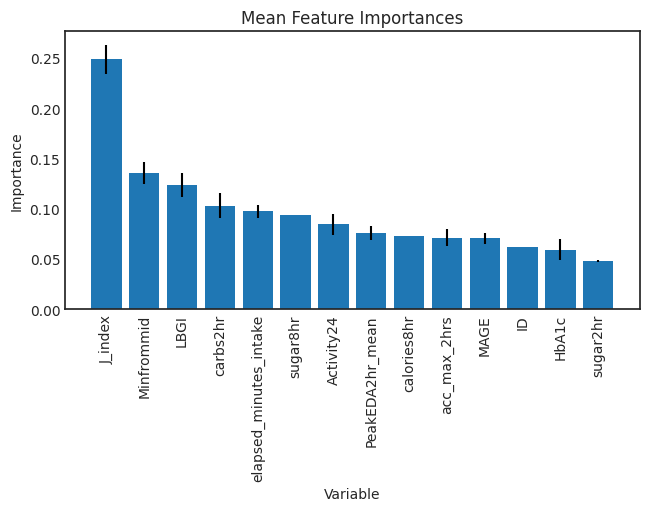

In [18]:
plt.style.use('seaborn-white')
x_values = list(range(len(filteredimp['importances'])))
# Make a bar chart
plt.bar(x_values, filteredimp['importances'], orientation = 'vertical', yerr=filteredimp['std'])# Tick labels for x axis
plt.xticks(x_values, filteredimp.index, rotation='vertical')# Axis labels and title
plt.tight_layout()
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title(('Mean Feature Importances'))
plt.show()

In [19]:
importances[importances['id'] == '1.0'].sort_values(by='importances', ascending=False).head(30)

,value,importances,id
6,J_index,0.255760,1.0
4,Minfrommid,0.139165,1.0
7,LBGI,0.125193,1.0
5,elapsed_minutes_intake,0.104946,1.0
1,carbs2hr,0.091924,1.0
3,PeakEDA2hr_mean,0.081479,1.0
2,acc_max_2hrs,0.077400,1.0
8,HbA1c,0.074785,1.0
0,sugar2hr,0.049347,1.0


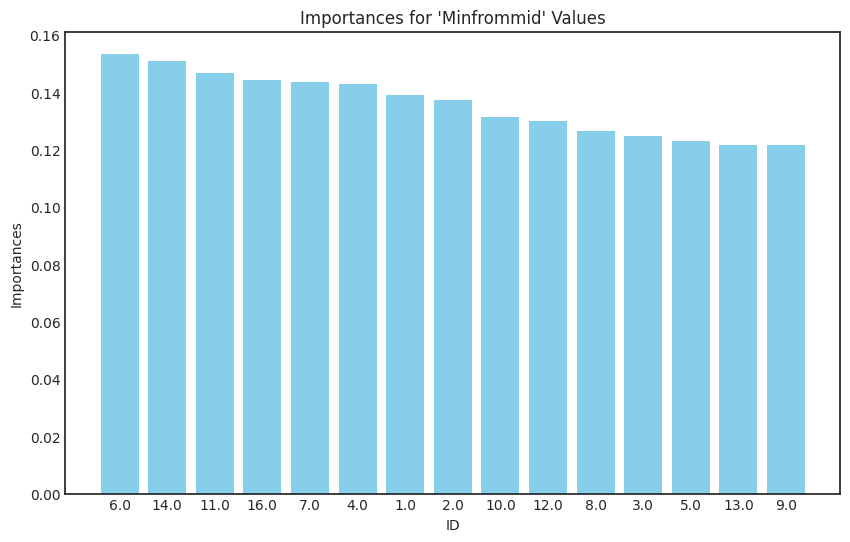

In [20]:
# 'value'가 'Minfrommid'인 항목 필터링
filtered_df = importances[importances['value'] == 'Minfrommid'].sort_values(by='importances', ascending=False)

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['id'], filtered_df['importances'], color='skyblue')
plt.xlabel('ID')
plt.ylabel('Importances')
plt.title("Importances for 'Minfrommid' Values")
plt.show()

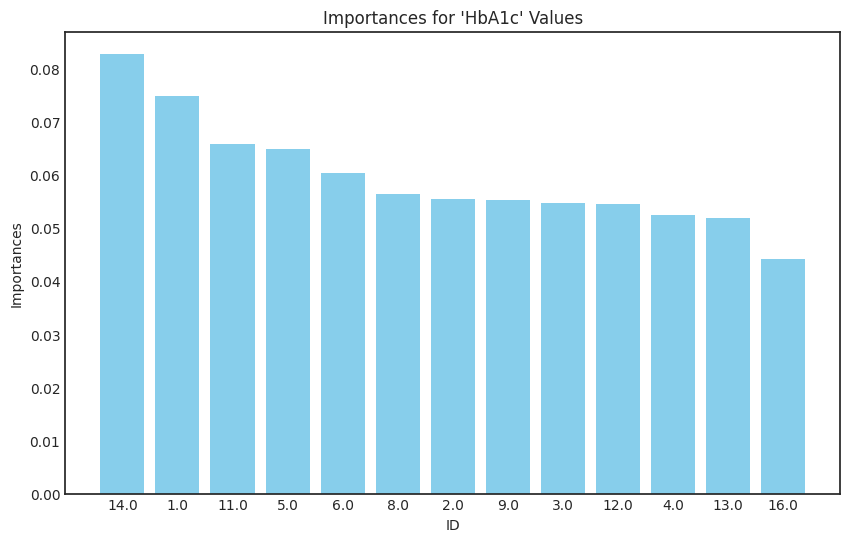

In [21]:
filtered_df = importances[importances['value'] == 'HbA1c'].sort_values(by='importances', ascending=False)

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['id'], filtered_df['importances'], color='skyblue')
plt.xlabel('ID')
plt.ylabel('Importances')
plt.title("Importances for 'HbA1c' Values")
plt.show()

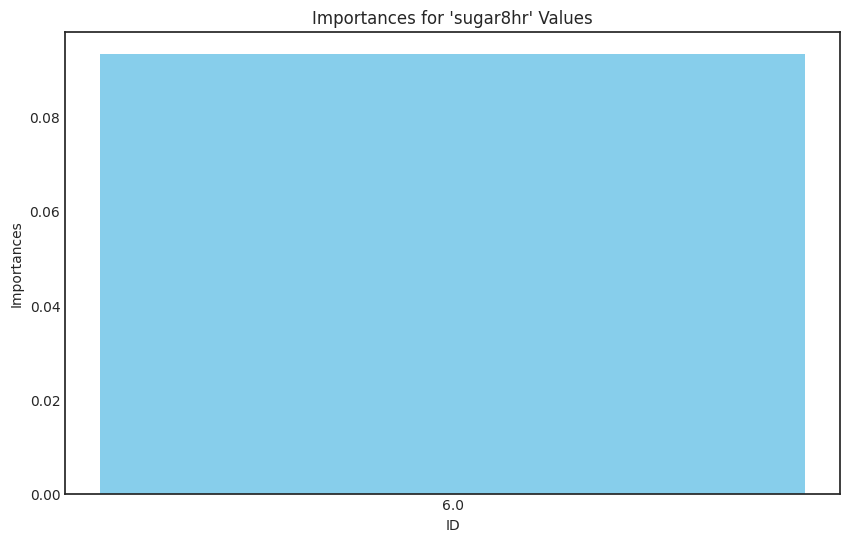

In [22]:
filtered_df = importances[importances['value'] == 'sugar8hr'].sort_values(by='importances', ascending=False)

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['id'], filtered_df['importances'], color='skyblue')
plt.xlabel('ID')
plt.ylabel('Importances')
plt.title("Importances for 'sugar8hr' Values")
plt.show()

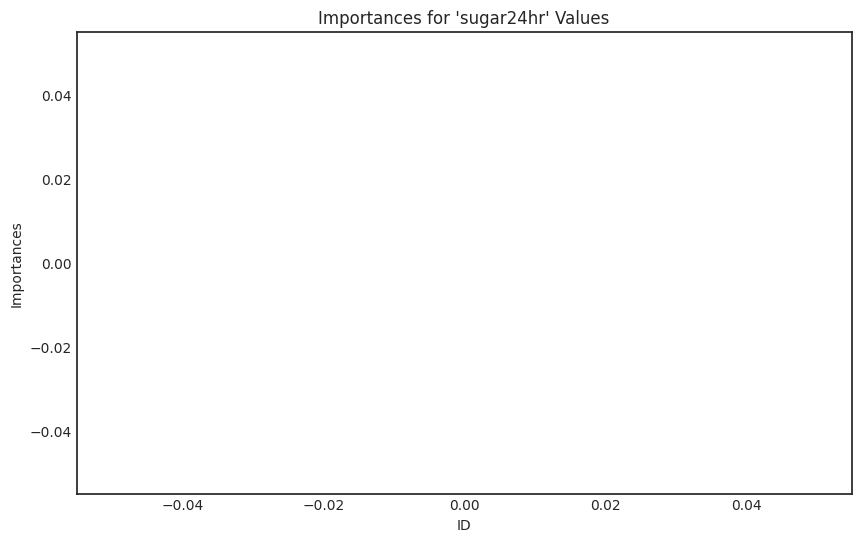

In [23]:
filtered_df = importances[importances['value'] == 'sugar24hr'].sort_values(by='importances', ascending=False)

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['id'], filtered_df['importances'], color='skyblue')
plt.xlabel('ID')
plt.ylabel('Importances')
plt.title("Importances for 'sugar24hr' Values")
plt.show()

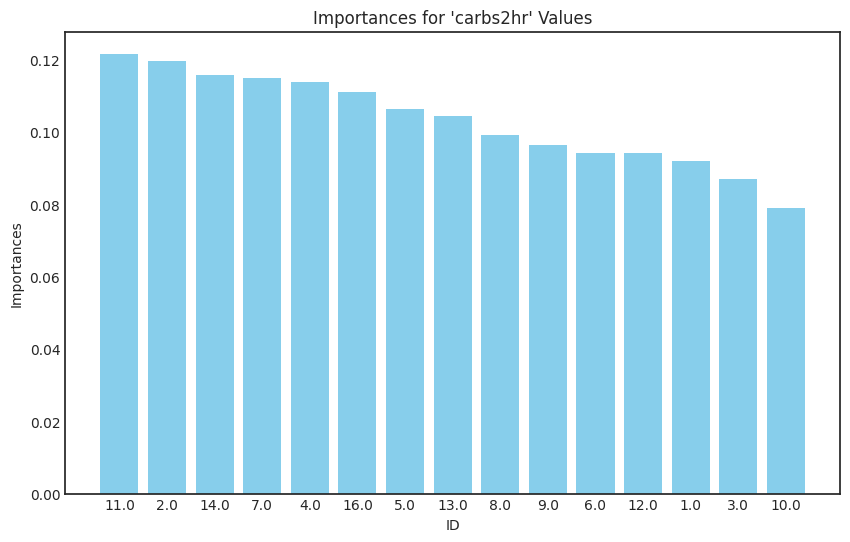

In [24]:
filtered_df = importances[importances['value'] == 'carbs2hr'].sort_values(by='importances', ascending=False)

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['id'], filtered_df['importances'], color='skyblue')
plt.xlabel('ID')
plt.ylabel('Importances')
plt.title("Importances for 'carbs2hr' Values")
plt.show()

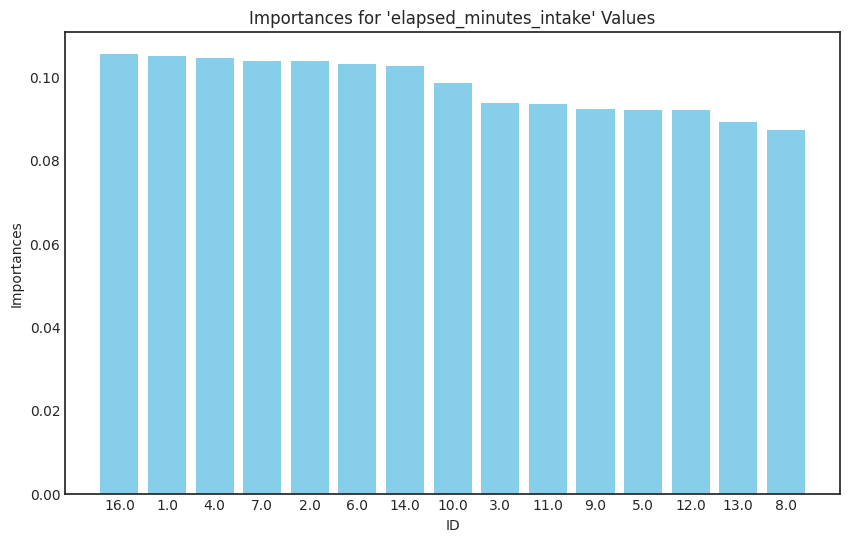

In [25]:
filtered_df = importances[importances['value'] == 'elapsed_minutes_intake'].sort_values(by='importances', ascending=False)

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['id'], filtered_df['importances'], color='skyblue')
plt.xlabel('ID')
plt.ylabel('Importances')
plt.title("Importances for 'elapsed_minutes_intake' Values")
plt.show()

In [26]:
importances[importances['id'] == '7.0'].sort_values(by='importances', ascending=False)

,value,importances,id
60,J_index,0.237097,7.0
58,Minfrommid,0.143782,7.0
61,LBGI,0.136048,7.0
54,carbs2hr,0.115030,7.0
59,elapsed_minutes_intake,0.103792,7.0
57,Activity24,0.098944,7.0
56,PeakEDA2hr_mean,0.084678,7.0
55,acc_max_2hrs,0.080629,7.0


## 3. 부분 개인화 교차 검증(partial personalization cross-validation) Model

In [27]:
from sklearn.metrics import roc_auc_score

def LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000, personalization_train_percent=0.5):
    """
        Intermediate function. Please use loocvRF function.
            
    """
    # Separate data for leave-one-person-out-cross-validation (LOOCV)
    LOOCV_O = ids 
    data[idcolumn] = data[idcolumn].apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]
    
    print(len(data_filtered))
    print(len(data_cv))

    train_cnt = int(len(data_cv) * personalization_train_percent)
    person_split_train = df.iloc[:train_cnt]
    person_split_test = df.iloc[train_cnt:]
    
    # Test data - the person left out of training
    data_test = person_split_test.drop(columns=dropcols)
    data_test = data_cv.drop(columns=dropcols)
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_filtered = pd.concat([person_split_train, data_filtered], ignore_index=True)
    data_train = data_filtered.drop(columns=dropcols)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    
    from sklearn.ensemble import RandomForestRegressor
    # Instantiate model with numestimators decision trees
    rf = RandomForestRegressor(n_estimators = numestimators, random_state = 0)
    # Train the model on training data
    print('Now processing... LOOCV_featureselection')
    rf.fit(X_train, y_train)
    
    # Get importances:
    importances = list(rf.feature_importances_)# List of tuples with variable and importance
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    
    return important

def RFLOOCV(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000, fs=0.02, personalization_train_percent=0.5):
    """
        Intermediate function. Please use loocvRF function.     
    """
    # Get important features
    listimportances = LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators, personalization_train_percent)
    filteredi = listimportances[listimportances['importances'] < fs]
    filteredi = filteredi['value']
    
    LOOCV_O = str(ids)
    data[idcolumn] = data[idcolumn].apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')


    train_cnt = int(len(data_cv) * personalization_train_percent)
    person_split_train = df.iloc[:train_cnt]
    person_split_test = df.iloc[train_cnt:]
   
    # Test data - the person left out of training
    data_test = person_split_test.drop(columns=dropcols)
    data_test = data_test.drop(columns=filteredi) #cvf
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_filtered = pd.concat([person_split_train, data_filtered], ignore_index=True)
    data_train = data_filtered.drop(columns=dropcols)
    data_train = data_train.drop(columns=filteredi)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    
    from sklearn.ensemble import RandomForestRegressor# Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = numestimators, random_state = 0)# Train the model on training data
    print('Now processing... RFLOOCV')
    rf.fit(X_train, y_train)
    
    # Use the forest's predict method on the test data
    test_predictions = rf.predict(X_test)
    train_predictions = rf.predict(X_train)
    errors = abs(test_predictions - y_test)
    
    # Root Mean Squared Error (RMSE)
    from sklearn import metrics
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, test_predictions))
    test_rmse = RMSE

    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_predictions))
    
    # Mean Average Percent Error (MAPE)
    MAPerror = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100 
    
    # List of tuples with variable and importance
    importances = list(rf.feature_importances_)
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    important['id'] = str(ids)
    
    return train_rmse, test_rmse, errors, RMSE, MAPerror, important

def partialPersonalizationLoocvRF(data, idcolumn, outcomevar, dropcols=[], numestimators=1000, fs=0.02, personalization_train_percent = 0.5):
    """
        Main loocv RF function that calls other functions to do RF feature selection, training, and testing. 

        Args:
          data (pandas DataFrame): This is a dataframe containing each participant's features and outcome variables
          idcolumn (string): This is the column name of your column containing your participant number or ID (case sensitive)
          outcomevar (string): This is the column name of your outcome variable (case sensitive)
          dropcols (list): This is a list containing strings of each column you wish to drop in your dataframe. Default is empty list [].
          numestimators (integer): The number of trees you want built in your RF. Default=1000.
          fs (float): The cutoff importance for feature selection. Anything below this importance will be removed for the RF training.
          
        Returns:
            errors (list): This is a list with the absolute error between the predicted value and actual value for each fold.
            meanrmse (float): This is the mean root mean squared error (RMSE) over all of the folds
            stdrmse (float): This is the standard deviation of the root mean squared error (RMSE) over all of the folds
            meanrmse (float): This is the mean mean average percent error (MAPE) over all of the folds
            meanrmse (float): This is the standard deviation of the mean average percent error (MAPE) over all of the folds
            importances(pandas DataFrame): This is a pandas DataFrame with 3 columns: value (feature), importances (importance of the feature), and id (fold over which this feature importance was derived)
            
    """
    
    # Make list of all ID's in idcolumn
    IDlist = list(data[idcolumn].astype(str).unique())
    print(f'IDlist : {IDlist}')
    drop = [] #drop = [idcolumn]
    drop = drop + dropcols
    
    # Initialize empty lists and dataframe 
    train_aucs = []
    test_aucs = []
    errors = []
    rmse = []
    mape = []
    eval_metrics = pd.DataFrame(columns=['rmse', 'mape', 'id'])
    importances = pd.DataFrame(columns=['value', 'importances', 'id'])
    rmse_df = pd.DataFrame(columns=['train_rmse','test_rmse', 'id'])
    
    # Run LOOCV Random Forest! 
    for i in IDlist:
        train_rmse, test_rmse, er, rm, ma, imp= RFLOOCV(data, i, outcomevar, drop, idcolumn, numestimators, fs, personalization_train_percent = personalization_train_percent)
        rmse_row = pd.DataFrame({'train_rmse': [train_rmse], 'test_rmse': [test_rmse], 'id': [str(i)]})
        rmse_df = pd.concat([rmse_df, rmse_row], ignore_index=True)
        errors.append(er)
        rmse.append(rm)
        mape.append(ma)
        eval = pd.DataFrame({'rmse': [rm], 'mape': [ma], 'id': [str(i)]})
        eval_metrics = pd.concat([eval_metrics, eval], ignore_index=True)
        importances = pd.concat([importances, imp], ignore_index=True)
        idt = str(i)
        print('...' + idt + ' processing complete.')

    # Compute mean and std RMSE, MAPE
    meanrmse = np.mean(rmse)
    stdrmse = np.std(rmse)
    meanmape = np.mean(mape)
    stdmape = np.std(mape)
    
    # Print RMSE, MAPE
    print('Mean RMSE:' + str(meanrmse))
    print('Std RMSE:' + str(stdrmse))
    print('Mean MAPE:' + str(meanmape))
    print('Std MAPE:' + str(stdmape))
    
    #TODO: 파라미터들을 담은 dataframe을 반환하도록 할 것.
    return rmse_df, eval_metrics, errors, meanrmse, stdrmse, meanmape, stdmape, importances

In [28]:
rmse_df, eval_df, errors, RMSE, RMSEstd, MAPE, MAPEstd, importances = partialPersonalizationLoocvRF(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'], numestimators=100, fs=0.02, personalization_train_percent=0.5)

IDlist : ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '16.0']
28870
2310
Now processing... LOOCV_featureselection
LOOCV_O : 1.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/tmp/ipykernel_75316/3783829856.py:161: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmse_df = pd.concat([rmse_df, rmse_row], ignore_index=True)
/tmp/ipykernel_75316/3783829856.py:166: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_metrics = pd.concat([eval_metrics, eval], ignore_index=True)
/tmp/ipykernel_75316/37

...1.0 processing complete.
29182
1998
Now processing... LOOCV_featureselection
LOOCV_O : 2.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...2.0 processing complete.
29155
2025
Now processing... LOOCV_featureselection
LOOCV_O : 3.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...3.0 processing complete.
29213
1967
Now processing... LOOCV_featureselection
LOOCV_O : 4.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...4.0 processing complete.
28897
2283
Now processing... LOOCV_featureselection
LOOCV_O : 5.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...5.0 processing complete.
28622
2558
Now processing... LOOCV_featureselection
LOOCV_O : 6.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...6.0 processing complete.
29184
1996
Now processing... LOOCV_featureselection
LOOCV_O : 7.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...7.0 processing complete.
28905
2275
Now processing... LOOCV_featureselection
LOOCV_O : 8.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...8.0 processing complete.
29163
2017
Now processing... LOOCV_featureselection
LOOCV_O : 9.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...9.0 processing complete.
29189
1991
Now processing... LOOCV_featureselection
LOOCV_O : 10.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...10.0 processing complete.
28613
2567
Now processing... LOOCV_featureselection
LOOCV_O : 11.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...11.0 processing complete.
29264
1916
Now processing... LOOCV_featureselection
LOOCV_O : 12.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...12.0 processing complete.
29491
1689
Now processing... LOOCV_featureselection
LOOCV_O : 13.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...13.0 processing complete.
29319
1861
Now processing... LOOCV_featureselection
LOOCV_O : 14.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...14.0 processing complete.
29453
1727
Now processing... LOOCV_featureselection
LOOCV_O : 16.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...16.0 processing complete.
Mean RMSE:5.495765042598753
Std RMSE:1.3706499665366234
Mean MAPE:1.6203534726009698
Std MAPE:0.2848945484058173


In [29]:
# Compute average of RMSE
avg_train_rmse = rmse_df['train_rmse'].mean()
avg_test_rmse = rmse_df['test_rmse'].mean()

In [30]:
rmse_df.head(15)

,train_rmse,test_rmse,id
0,1.467472,3.210902,1.0
1,1.431557,6.324601,2.0
2,1.473786,4.967984,3.0
3,1.506921,5.313221,4.0
4,1.483326,3.795444,5.0
5,1.429172,8.612753,6.0
6,1.480029,5.396096,7.0
7,1.461524,4.004197,8.0
8,1.485280,5.729107,9.0
9,1.464388,7.417226,10.0


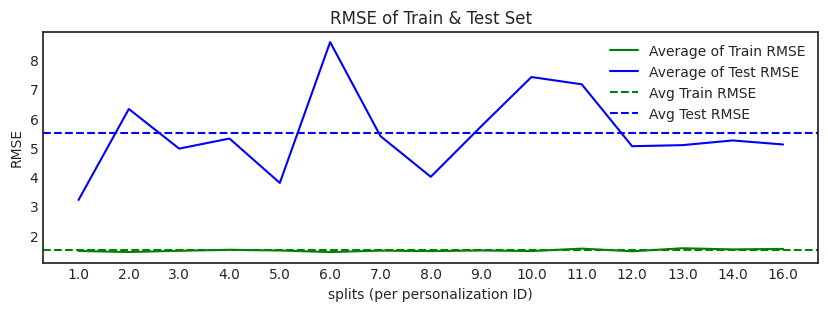

In [31]:
# 그래프 그리기
plt.figure(figsize=(10, 3))
plt.plot(rmse_df['id'], rmse_df['train_rmse'], 'g', label='Average of Train RMSE')
plt.plot(rmse_df['id'], rmse_df['test_rmse'], 'b', label='Average of Test RMSE')

# 가로 점선 추가
plt.axhline(y=avg_train_rmse, color='g', linestyle='--', label='Avg Train RMSE')
plt.axhline(y=avg_test_rmse, color='b', linestyle='--', label='Avg Test RMSE')

plt.title('RMSE of Train & Test Set')
plt.xlabel('splits (per personalization ID)')
plt.ylabel('RMSE')
plt.legend()

In [32]:
eval_df.head(20)

,rmse,mape,id
0,3.210902,1.069336,1.0
1,6.324601,1.694206,2.0
2,4.967984,1.496410,3.0
3,5.313221,1.613435,4.0
4,3.795444,1.481007,5.0
5,8.612753,2.258118,6.0
6,5.396096,1.970127,7.0
7,4.004197,1.430579,8.0
8,5.729107,1.550512,9.0
9,7.417226,1.762442,10.0


In [33]:
imp_err = importances.groupby('value').std(numeric_only=True).rename(columns={'importances':'std'})#.sort_values(by='importances', ascending=False)

In [34]:
filteredimp = importances.groupby('value').mean(numeric_only=True).sort_values(by='importances', ascending=False)
filteredimp = pd.merge(filteredimp, imp_err, on='value')
print(filteredimp)

                        importances       std
value                                        
J_index                    0.251882  0.015308
LBGI                       0.130419  0.014324
Minfrommid                 0.130042  0.009238
carbs2hr                   0.102223  0.012740
elapsed_minutes_intake     0.092912  0.006480
Activity24                 0.087087  0.013573
sugar8hr                   0.082821       NaN
CONGA2                     0.081944       NaN
PeakEDA2hr_mean            0.074951  0.007508
CONGA1                     0.074538       NaN
MAGE                       0.070366  0.006097
acc_max_2hrs               0.069651  0.007346
calories8hr                0.067110       NaN
ID                         0.066957       NaN
HbA1c                      0.052910  0.009873
sugar2hr                   0.041886  0.004684


/tmp/ipykernel_75316/3888890867.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


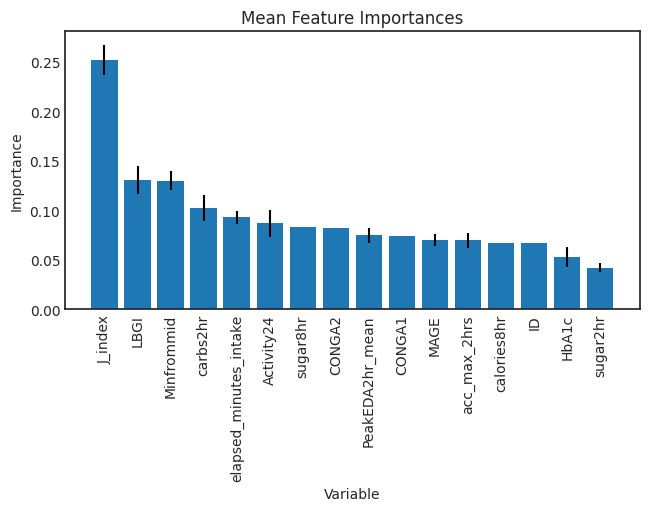

In [35]:
plt.style.use('seaborn-white')
x_values = list(range(len(filteredimp['importances'])))
# Make a bar chart
plt.bar(x_values, filteredimp['importances'], orientation = 'vertical', yerr=filteredimp['std'])# Tick labels for x axis
plt.xticks(x_values, filteredimp.index, rotation='vertical')# Axis labels and title
plt.tight_layout()
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title(('Mean Feature Importances'))
plt.show()

In [36]:
'''
avg_test_auc_list = []
avg_train_auc_list = []

for i in range(5): # i*10 (%) for train_split
    avg_train_auc, avg_test_auc, eval_df, errors, RMSE, RMSEstd, MAPE, MAPEstd, importances = partialPersonalizationLoocvRF(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'], numestimators=100, fs=0.02, personalization_train_percent=i*0.1)
    avg_train_auc_list.append(avg_train_auc)
    avg_test_auc_list.append(avg_test_auc)
'''

"\navg_test_auc_list = []\navg_train_auc_list = []\n\nfor i in range(5): # i*10 (%) for train_split\n    avg_train_auc, avg_test_auc, eval_df, errors, RMSE, RMSEstd, MAPE, MAPEstd, importances = partialPersonalizationLoocvRF(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'], numestimators=100, fs=0.02, personalization_train_percent=i*0.1)\n    avg_train_auc_list.append(avg_train_auc)\n    avg_test_auc_list.append(avg_test_auc)\n"